# Modelagem Preditiva com ARIMA
---

Para a análise e treinamento do modelo ARIMA utilizaremos da biblioteca statsmodel, utilizaremos ela também
para realizar calculos estátisticos mais complexos.

### Instalando as depêndencias

In [3]:
!pip install pandas
!pip install matplotlib
!pip install pyarrow
!pip install fastparquet
!pip install statsmodels
!pip install prophet


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ------- -------------------------------- 2.4/12.1 MB 11.9 MB/s eta 0:00:01
   ------------- -------------------------- 4.2/12.1 MB 11.8 MB/s eta 0:00:01
   ------------------- -------------------- 6.0/12.1 MB 10.0 MB/s eta 0:00:01
   --------------------------- ------------ 8.4/12.1 MB 10.5 MB/s eta 0:00:01
   ----------------------------------- ---- 10.7/12.1 MB 10.7 MB/s eta 0:00:01
   ---------------------------------------- 12.1/12.1 MB 10.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 6.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Carregando o dataset

In [7]:
import pandas as pd

parquet_path = "../data/dataset/data_final_optimized.parquet"

data = pd.read_parquet(parquet_path)
print(data)
print("✅Carregamento concluído.")

               station  year  month  day element  value mflag qflag sflag  \
0          AE000041196  1944      3   20    TMAX    380                 I   
1          AE000041196  1944      3   21    TMAX    346                 I   
2          AE000041196  1944      3   22    TMAX    319                 I   
3          AE000041196  1944      3   23    TMAX    302                 I   
4          AE000041196  1944      3   24    TMAX    296                 I   
...                ...   ...    ...  ...     ...    ...   ...   ...   ...   
101697729  ZI000067983  2025      8   19    TAVG    167     H           S   
101697730  ZI000067983  2025      8   20    TAVG    196     H           S   
101697731  ZI000067983  2025      8   21    TAVG    208     H           S   
101697732  ZI000067983  2025      8   22    TAVG    240     H           S   
101697733  ZI000067983  2025      8   23    TAVG    233     H           S   

                date  
0         1944-03-20  
1         1944-03-21  
2     

### Escolhendo a estação alvo

Para o treinamento e análise do modelo iremos afunilar os dados para a estação **AE000041196** e validar os dados de temperatura máxima registrada pela estação.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

#Filtrando o dataset
data_temporaria = data[(data['station'] == 'AE000041196') & (data['element'] == 'TMAX')].copy()
data_temporaria['date'] = pd.to_datetime(data_temporaria[['year', 'month', 'day']])

df_ts = data_temporaria.set_index('date')['value'].asfreq('D') # Definimos a frequência como diária

df_ts = df_ts.dropna() # Removemos os valores nulos

# Decompondo a série temporal
---
Realizando a decomposição dos dados da estação conseguimos notar a falta de registros metereológicos em determinados anos,
além disso conseguimos notar um padrão claro de sazonalidade nos periodos de registro da estação, possuindo picos e vales nos registros
de temperatura máxima

<Figure size 1200x800 with 0 Axes>

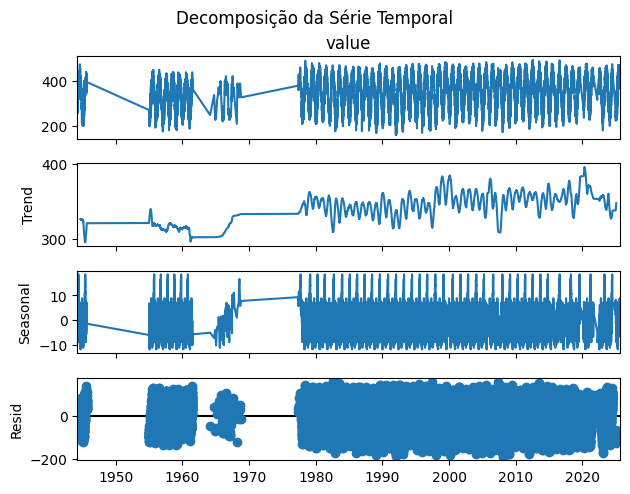

In [4]:
decomposition = seasonal_decompose(df_ts, model='additive', period=365)

plt.figure(figsize=(12, 8))
decomposition.plot()

plt.suptitle('Decomposição da Série Temporal', y=1.02)
plt.show()

### Determinando a ordem de derivação para a série estacionaria

Para a implementação do algoritmo ARIMA, é necessário que a nossa série temporal esteja em formato estácionario, isto significa que a
média, variancia e autocorrelação não devem mudar ao longo do tempo.

Para isso montamos uma função recursiva que deriva nossa série temporal até alcancar um P-valor de 0.05 (mantendo 95% de confiabilidade).

* Como a série temporal precisou de somente uma derivação deixei o valor de D (que é o numero de derivações) como 1

### Resultado do Teste ADF ###

✅ A série é Estacionária (Rejeita-se H0).


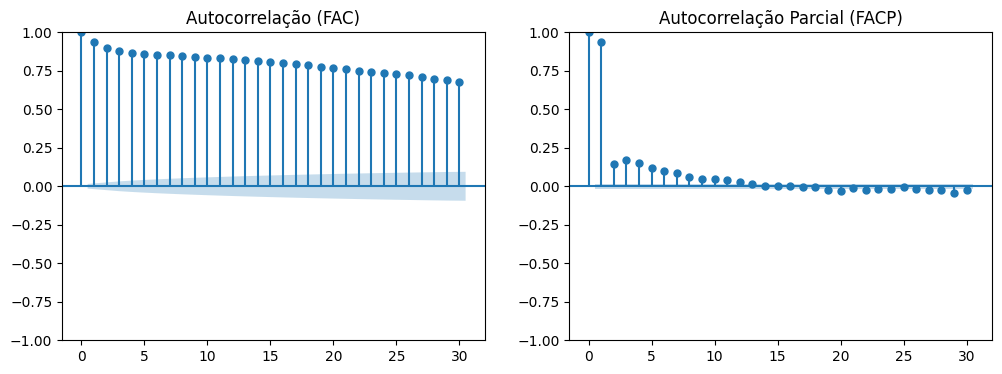

In [5]:
def check_stationarity(timeseries):
    # Teste ADFs
    result = adfuller(timeseries, autolag='AIC')
    print('### Resultado do Teste ADF ###')

    if result[1] <= 0.05:
        print("\n✅ A série é Estacionária (Rejeita-se H0).")
        return timeseries
    else:
        print("\n❌ A série NÃO é Estacionária")
        
        # Aplicar diferenciação de primeira ordem
        ts_diff = timeseries.diff().dropna()
        print(f"\n--- Após Diferenciação (d=1) ---")
        return check_stationarity(ts_diff) # Checa novamente a estacionariedade

df_stationary = check_stationarity(df_ts)

plt.figure(figsize=(12, 4))
plot_acf(df_stationary, lags=30, ax=plt.subplot(121), title='Autocorrelação (FAC)')
plot_pacf(df_stationary, lags=30, ax=plt.subplot(122), title='Autocorrelação Parcial (FACP)')
plt.show()

# Estimando os valores para P e Q

Já possuimos o valor de D, agora precisamos dos valores de P e Q.
Para isso definimos um intervalo de valores provaveis para P e Q, estes sendo 3-tuplas com todas as combinações possiveis entre 1 e 3.

A métrica Akaike(aic) é utilizada para quantificar a qualidade do modelo treinado, usamos ele para identificar qual os melhores valores de P e Q para o modelo ARIMA. 

In [6]:
# Exemplo de Grid Search simples
import itertools
best_aic = np.inf
best_order = None

p_values = range(0, 3)
q_values = range(0, 3)

# Retorna uma lista com todas as combinações possiveis de valores para Q e P
pdq = list(itertools.product(p_values, [1], q_values))

for order in pdq:
    #Elegendo o melhor valor para o modelo
    try:
        model_test = ARIMA(df_ts, order=order)
        model_fit = model_test.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = order
    except:
        continue

print(f"\nMelhor ordem (p, d, q) encontrada: {best_order} com AIC: {best_aic:.2f}")


Melhor ordem (p, d, q) encontrada: (2, 1, 2) com AIC: 152199.98


### Treinando o modelo ARIMA
---

Iremos treinar o modelo com 80% dos dados do nosso Dataset, mantendo 20% deles para o teste de previsão

In [ ]:
train_size = int(len(df_ts) * 0.8)
train, test = df_ts[:train_size], df_ts[train_size:]
seasonal_order = (1, 1, 1, 365)

final_model = ARIMA(train, order=best_order)
final_model_fit = final_model.fit()

print(final_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                13369
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -60828.898
Date:                Sun, 30 Nov 2025   AIC                         121667.795
Time:                        13:55:46   BIC                         121705.298
Sample:                             0   HQIC                        121680.309
                              - 13369                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5682      0.009    182.253      0.000       1.551       1.585
ar.L2         -0.5785      0.008    -68.389      0.000      -0.595      -0.562
ma.L1         -1.8983      0.005   -390.088      0.0

### Visualizando as previsões realizadas pelo modelo ARIMA
---
Realizamos a previsão dos dados de test com o ARIMA, criamos um dataset com os valores das previsões para a visualização.
Aqui conseguimos notar um grande problema na implementação do ARIMA, ele ignora completamente os eventos de sazonalidade da série temporal, o que ocasional em uma linha vermelha quase horizontal.

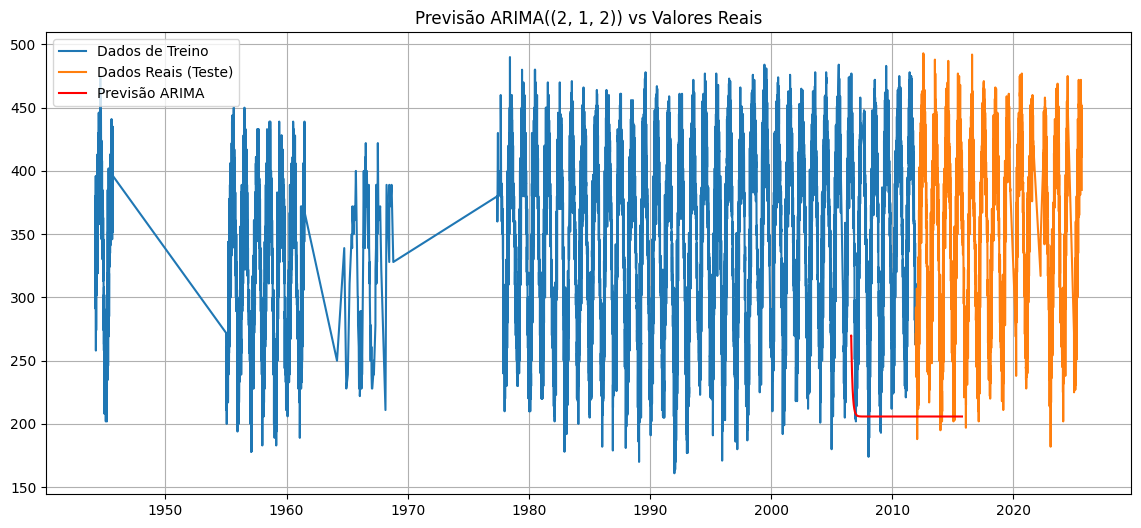

In [ ]:

steps = len(test)
forecast = final_model_fit.forecast(steps=steps)

# Criar um DataFrame para o resultado e renomear as colunas para clarezas
forecast_results = pd.DataFrame({
    'Actual': test,
    'Forecast': forecast.values
})
forecast_results.index = test.index

## Plot dos Resultados
plt.figure(figsize=(14, 6))
plt.plot(train, label='Dados de Treino')
plt.plot(test, label='Dados Reais (Teste)')
plt.plot(forecast, label='Previsão ARIMA', color='red')
plt.title(f'Previsão ARIMA({order}) vs Valores Reais')
plt.legend()
plt.grid(True)
plt.show()

### Plot dos ruidos

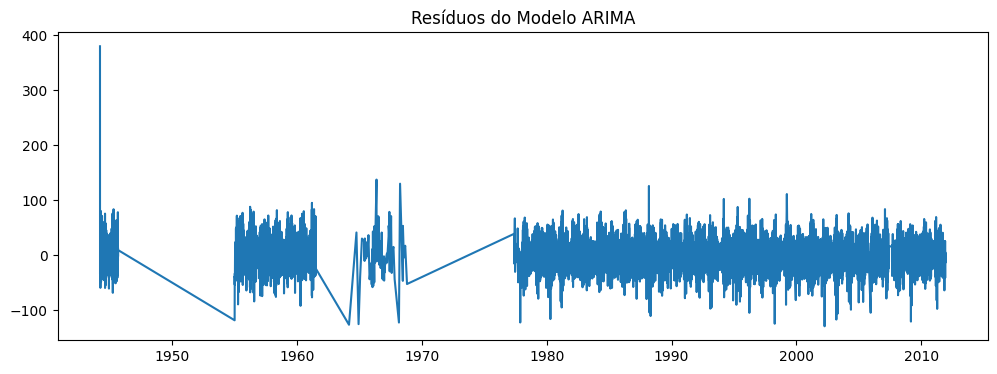


Teste de Ljung-Box para Resíduos:
p-valor: 0.0001


In [ ]:
residuals = final_model_fit.resid
plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title('Resíduos do Modelo ARIMA')
plt.show()

# Um p-valor alto (> 0.05) indica que os resíduos são ruído branco
from statsmodels.stats.diagnostic import acorr_ljungbox
ljungbox_test = acorr_ljungbox(residuals, lags=[10])
print("\nTeste de Ljung-Box para Resíduos:")
print(f"p-valor: {ljungbox_test.iloc[0]['lb_pvalue']:.4f}")

### Análise quantitativa da previsão

In [ ]:
# Cálculo do MSE
mse = mean_squared_error(test, forecast)
print(f"\nErro Quadrático Médio (MSE): {mse:.4f}")

# Cálculo do RMSE
rmse = np.sqrt(mse)
# O RMSE está na mesma unidade da temperatura (ex: 0.1ºC para o valor "value" do dataset)

print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.4f}")

NameError: name 'mean_squared_error' is not defined

# Previsão utilizando o Prophet
---
O Prophet (desenvolvido pelo Facebook/Meta) é uma excelente escolha para esse tipo de dataset (dados climáticos), pois ele foi projetado especificamente para lidar com sazonalidade forte e dados faltantes (NaNs) de forma muito mais robusta e automática do que o ARIMA.

Seguimos pela mesma linha da análise realizada com o ARIMA, separamos a estação e os dados de temperatura máxima.
O modelo também nos permite avaliar o ciclo anual de temperatura separado da tendência de aquecimento/resfriamento

15:53:55 - cmdstanpy - INFO - Chain [1] start processing
15:54:06 - cmdstanpy - INFO - Chain [1] done processing


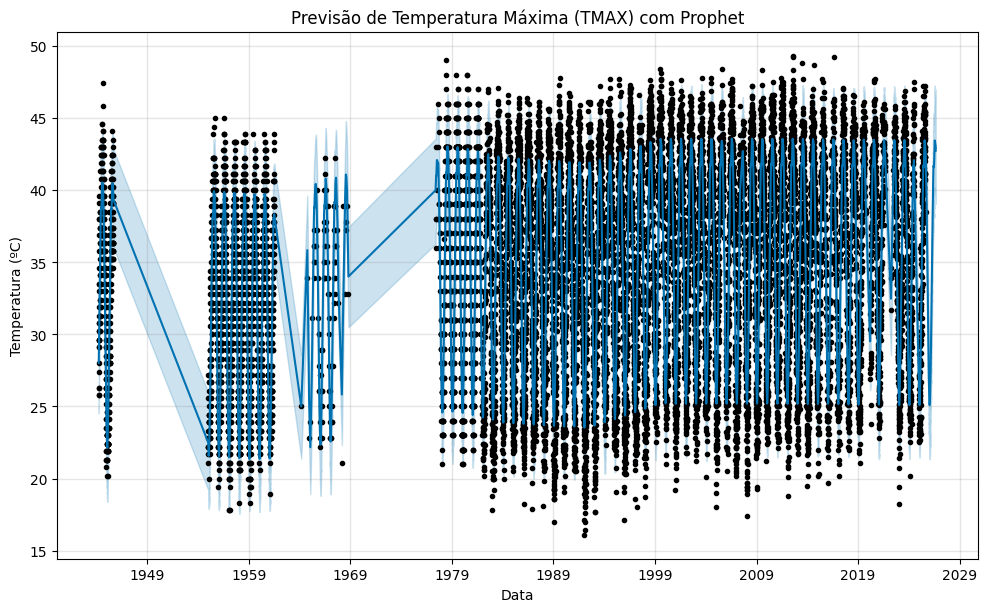

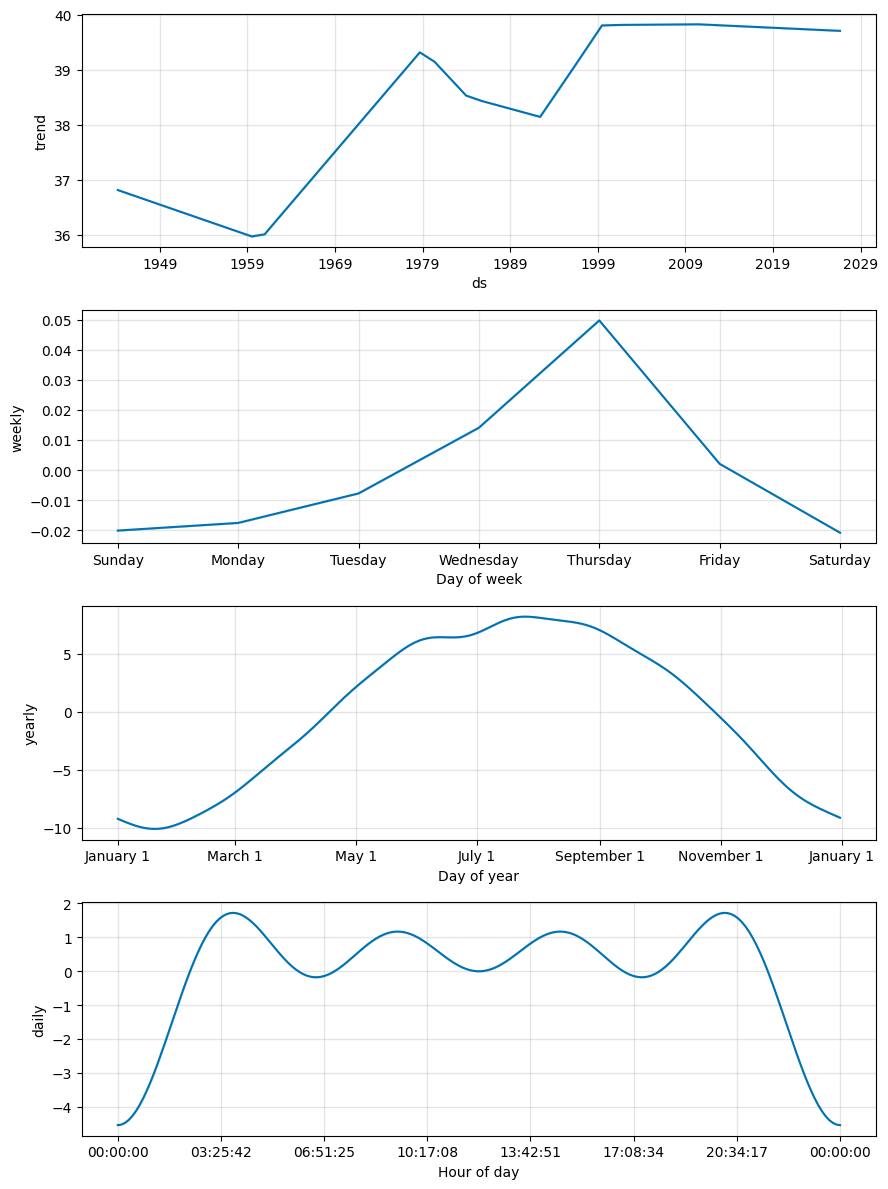

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


df_prophet = data[(data['station'] == 'AE000041196') & (data['element'] == 'TMAX')].copy()
df_prophet['date'] = pd.to_datetime(df_prophet['date'])

# Esta formatação para as colunas é necessaria para o funcionamento do modelo
df_train = pd.DataFrame()
df_train['ds'] = df_prophet['date']
df_train['y'] = df_prophet['value'] * 0.1

# Não precisamos informar os parametros, pois ele já detecta sozinho
# a sazonalidade
model = Prophet(yearly_seasonality=True, daily_seasonality=True)
model.fit(df_train)

future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Plot da previsão
fig1 = model.plot(forecast)
plt.title('Previsão de Temperatura Máxima (TMAX) com Prophet')
plt.xlabel('Data')
plt.ylabel('Temperatura (ºC)')
plt.show()

fig2 = model.plot_components(forecast)
plt.show()